In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

IMAGES_DIR = "/mnt/spin6TB/dirkgr/images"
IMAGES_DIR = "/Users/marvin/Downloads/images"
MAX_IMAGE_SIZE = (500, 500)
INPUT_SIZE = (MAX_IMAGE_SIZE[0] / 2, MAX_IMAGE_SIZE[1] / 2)

BATCH_SIZE = 4

In [3]:
import os
def allImageFilenames(directory):
    for root, dirs, files in os.walk(directory):
        for f in files:
            if f.endswith(".jpg"):
                yield os.path.join(root, f)

import skimage.io
def allRawImages(filenames):
    for filename in filenames:
        image = skimage.io.imread(filename)
        if image.shape[0] > MAX_IMAGE_SIZE[0]:
            raise ValueError("Image %s too big: %r" % (filename, image.shape))
        if image.shape[1] > MAX_IMAGE_SIZE[1]:
            raise ValueError("Image %s too big: %r" % (filename, image.shape))
        yield image
        
import skimage.util
def padImage(image):
    widthFactor = MAX_IMAGE_SIZE[0] - image.shape[0]
    heightFactor = MAX_IMAGE_SIZE[1] - image.shape[1]
    padValues = (
        (widthFactor / 2, widthFactor / 2 + widthFactor % 2),
        (heightFactor / 2, heightFactor / 2 + heightFactor % 2),
        (0, 0)
    )
    result = skimage.util.pad(image, padValues, 'constant', constant_values=0)
    return result

import skimage.transform
def scaleDown(image):
    return skimage.transform.rescale(image, 0.5)

def floatImage(image):
    return skimage.util.img_as_float(image)

import numpy
def axisFormatToKeras(image):
    return numpy.moveaxis(image, 2, 0)
def axisFormatFromKeras(image):
    return numpy.moveaxis(image, 0, 2)

filenames = list(allImageFilenames(IMAGES_DIR))
TRAIN_VALIDATE_TEST_FRACTIONS = (0.7, 0.2, 0.1)
cutoffs = (
    int(len(filenames) * TRAIN_VALIDATE_TEST_FRACTIONS[0]),
    int(len(filenames) * TRAIN_VALIDATE_TEST_FRACTIONS[0] + TRAIN_VALIDATE_TEST_FRACTIONS[1])
)
filenames_train = filenames[:cutoffs[0]]
filenames_validate = filenames[cutoffs[0]:cutoffs[1]]
filenames_test = filenames[cutoffs[1]:]

def makeData(filenames):
    for rawImage in allRawImages(filenames):
        padded = floatImage(padImage(rawImage))
        yield map(axisFormatToKeras, (scaleDown(padded), padded))
        
def loopInfinitely(generatorGenerator):
    while True:
        for item in generatorGenerator():
            yield item
            
def makeInfiniteDataBatches(filenames):
    def makeGeneratorFromBeginning():
        return makeData(filenames)
    generator = loopInfinitely(makeGeneratorFromBeginning)
    accumulator = []
    for item in generator:
        accumulator.append(item)
        if len(accumulator) >= BATCH_SIZE:
            # accumulator is now a list of (input, label) tuples
            accumulator = zip(*accumulator)
            # accumulator is now a list of length 2, like this: [(input1, input2, ...), (label1, label2, ...)]
            yield map(numpy.stack, accumulator)
            accumulator = []
        
train = makeInfiniteDataBatches(filenames_train)
validate = makeInfiniteDataBatches(filenames_validate)
test = makeInfiniteDataBatches(filenames_test)

In [5]:
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.convolutional import Convolution2D, UpSampling2D

model = Sequential()
model.add(Convolution2D(16, 5, 5, activation="relu", border_mode='same', input_shape = (3,) + INPUT_SIZE))
model.add(UpSampling2D())
model.add(Convolution2D(16, 5, 5, activation="relu", border_mode='same'))
model.add(Convolution2D(3, 5, 5, activation="relu", border_mode='same'))
model.add(Activation("tanh"))
model.summary()
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_5 (Convolution2D)  (None, 16, 250, 250)  1216        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
upsampling2d_2 (UpSampling2D)    (None, 16, 500, 500)  0           convolution2d_5[0][0]            
____________________________________________________________________________________________________
convolution2d_6 (Convolution2D)  (None, 16, 500, 500)  6416        upsampling2d_2[0][0]             
____________________________________________________________________________________________________
convolution2d_7 (Convolution2D)  (None, 3, 500, 500)   1203        convolution2d_6[0][0]            
___________________________________________________________________________________________

In [10]:
model.fit_generator(
    train,
    samples_per_epoch = 256,
    nb_epoch = 16)

#    validation_data = validate,
#    nb_val_samples = 256)

Epoch 1/16
256/256 [==============================] - 1118s - loss: 0.0050 - acc: 0.0708   
Epoch 2/16
256/256 [==============================] - 1061s - loss: 0.0036 - acc: 0.0907   
Epoch 3/16
256/256 [==============================] - 1075s - loss: 0.0034 - acc: 0.1334   
Epoch 4/16
256/256 [==============================] - 1125s - loss: 0.0033 - acc: 0.1002   
Epoch 5/16
256/256 [==============================] - 1118s - loss: 0.0037 - acc: 0.1286   
Epoch 6/16
256/256 [==============================] - 1146s - loss: 0.0030 - acc: 0.1309   
Epoch 7/16
256/256 [==============================] - 1207s - loss: 0.0025 - acc: 0.1327   
Epoch 8/16
256/256 [==============================] - 1109s - loss: 0.0027 - acc: 0.1564   
Epoch 9/16
256/256 [==============================] - 910s - loss: 0.0026 - acc: 0.1422    
Epoch 10/16
256/256 [==============================] - 903s - loss: 0.0025 - acc: 0.1432    
Epoch 11/16
256/256 [==============================] - 937s - loss: 0.0029 - ac

In [15]:
model.evaluate_generator(test, 256)

#plt.imshow(scaledImage)
#plt.imshow(paddedImage)

[0.0028349761414574459, 0.16457812441512942]

In [20]:
(scaledDownBatch, originalBatch) = test.next() 
resultBatch = model.predict_on_batch(scaledDownBatch)

firstResult = resultBatch[0]
firstResult = axisFormatFromKeras(firstResult)

firstOriginal = originalBatch[0]
firstOriginal = axisFormatFromKeras(firstOriginal)

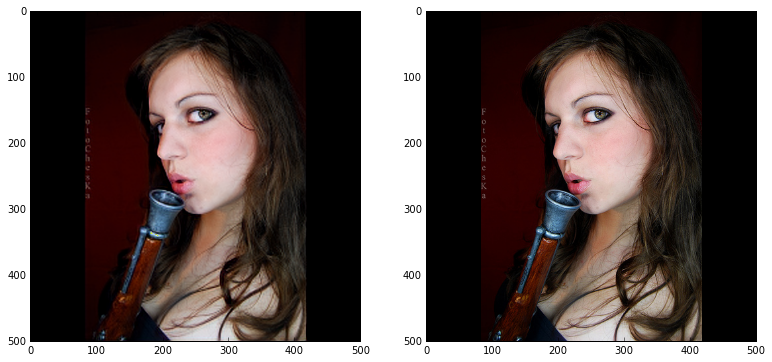

In [21]:
f, (resultFig, originalFig) = plt.subplots(1, 2)
f.set_figheight(600/92)
f.set_figwidth(1200/92)
resultFig.imshow(firstResult)
originalFig.imshow(firstOriginal)